<a href="https://colab.research.google.com/github/praffuln/agentic-ai/blob/master/langgraph_agentic_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# prompt: print hello world

print("hello world")


hello world


In [ ]:
!pip install google-generativeai tiktoken chromadb langgraph langchain langchain_community langchainhub ipykernel langchain_groq sentence_transformers


In [27]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

## Setup Keys For GOOGLE_API_KEY


In [28]:

# Assigning value to variable
GEMINI_API_KEY=''
SERPER_API_KEY = ''
GROQ_API_KEY = ''



# setup environments


In [29]:
import os
os.environ['SERPER_API_KEY'] = SERPER_API_KEY
os.environ['GEMINI_API_KEY'] = GEMINI_API_KEY
os.environ['GROQ_API_KEY'] = GROQ_API_KEY




## setup LLM

In [30]:
import google.generativeai as genai

genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content("Explain how AI works")
print(response.text)


Artificial intelligence (AI) is a broad field encompassing various techniques that enable computers to mimic human intelligence.  There's no single "how it works" answer, as different AI approaches utilize different methods. However, we can break it down into several key concepts:

**1. Data is King:**  AI systems learn from data.  The more relevant and high-quality data they are trained on, the better they perform. This data can be anything from images and text to sensor readings and financial transactions.

**2. Algorithms and Models:**  AI uses algorithms – sets of rules and statistical techniques – to process and learn from data. These algorithms are implemented as models, which are mathematical representations of the problem the AI is trying to solve.  Examples include:

* **Machine Learning (ML):**  This is a subset of AI where systems learn from data without explicit programming.  Instead of being explicitly programmed with rules, they identify patterns and relationships in the 

In [ ]:
from langchain_groq import ChatGroq
from sentence_transformers import SentenceTransformer # Import SentenceTransformer instead of GroqEmbedding


llm = ChatGroq(model="mixtral-8x7b-32768")

llm.invoke("tell me something about ai")

# Now use SentenceTransformer for embedding
embedding_model = SentenceTransformer('all-mpnet-base-v2')  # Choose a suitable pre-trained model
embedding = embedding_model.encode("tell me something about ai")

print(embedding) # Print the embedding to see the result

## Load Data

In [32]:
urls= ["https://lilianweng.github.io/posts/2023-06-23-agent/",
      "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/"]
docs = [WebBaseLoader(url).load() for url in urls]

docs[0][0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [ ]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=5)
doc_splits=text_splitter.split_documents(docs_list)
doc_splits

In [34]:

from langchain_community.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")


vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embedding_model
)


In [35]:
retriever=vectorstore.as_retriever()


### convert retriever to tool

In [36]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",

)

In [37]:
tools=[retriever_tool]

## Fuctions & Graph

In [38]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [39]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'")

In [40]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)

    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant.
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op

    messages = state["messages"]
    print(f"message from the grader: {messages}")
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name


In [41]:
def ai_assistant(state):
    print("---CALL AGENT---")
    messages = state['messages']
    print(f"this is my message: {messages}")

    llm_with_tool = llm.bind_tools(tools)
    response = llm_with_tool.invoke(messages)
    #response=handle_query(messages)
    return {"messages": [response]}



    # print("---CALL AGENT---")
    # messages = state['messages']
    # print(f"this is my message: {messages}")

    # if len(messages)>1:
    #     response=llm.invoke(messages[-1].content)
    #     return {"messages": [response]}
    # else:
    #     llm_with_tool = llm.bind_tools(tools)
    #     response = llm_with_tool.invoke(messages)
    #     #response=handle_query(messages)
    #     return {"messages": [response]}


In [42]:
def retrieve(state):
  pass

In [43]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    print(f"here is message from rewrite: {messages}")

    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning.
                    Here is the initial question: {question}
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}


In [44]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    print(f"here is message from generate: {messages}")

    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content

    prompt = """
                You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
                If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
                Question: {question}
                Context: {context}
                Answer:
            """

    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")

    return {"messages": [response]}


In [45]:
workflow=StateGraph(AgentState)
workflow.add_node("ai_assistant",ai_assistant)
retrieve=ToolNode([retriever_tool])   ### way to add retriever_tool under node
workflow.add_node("retriever", retrieve)
workflow.add_node("rewriter", rewrite)
workflow.add_node("generator", generate)


In [46]:
workflow.add_edge(START, "ai_assistant")

workflow.add_conditional_edges("ai_assistant",
                               tools_condition,
                               {"tools": "retriever",
                                END: END,})

workflow.add_conditional_edges("retriever",
                            grade_documents,
                            {"generator": "generator",
                            "rewriter": "rewriter"
                            }
                            )

workflow.add_edge("generator", END)

workflow.add_edge("rewriter", "ai_assistant")


In [47]:
app = workflow.compile()

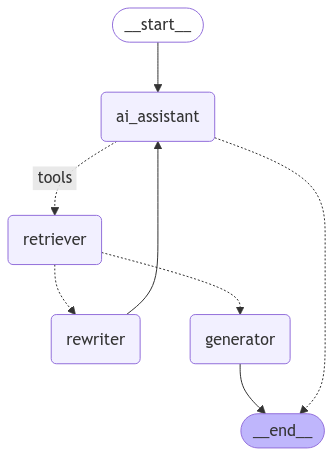

In [51]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [48]:
app.invoke({"messages": [HumanMessage(content="tell me something about ai")]})

---CALL AGENT---
this is my message: [HumanMessage(content='tell me something about ai', additional_kwargs={}, response_metadata={}, id='a6f103f5-f66e-4a69-b5f3-8412e93d6bf2')]


{'messages': [HumanMessage(content='tell me something about ai', additional_kwargs={}, response_metadata={}, id='a6f103f5-f66e-4a69-b5f3-8412e93d6bf2'),
  AIMessage(content="AI, or artificial intelligence, is a field of computer science that focuses on creating smart machines capable of performing tasks that would typically require human intelligence. This includes activities such as learning, reasoning, problem-solving, perception, and language understanding. AI has various applications, including gaming, voice recognition, and self-driving cars. It's a rapidly evolving field, with ongoing research to create even more sophisticated and intelligent systems.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 1267, 'total_tokens': 1356, 'completion_time': 0.136576439, 'prompt_time': 0.142741537, 'queue_time': 0.02003823099999999, 'total_time': 0.279317976}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish

In [49]:
app.invoke({"messages": [HumanMessage(content="what is autonomous agent ?")]})

---CALL AGENT---
this is my message: [HumanMessage(content='what is autonomous agent ?', additional_kwargs={}, response_metadata={}, id='d3711457-4f1b-4701-8a10-30df104af6fe')]


{'messages': [HumanMessage(content='what is autonomous agent ?', additional_kwargs={}, response_metadata={}, id='d3711457-4f1b-4701-8a10-30df104af6fe'),
  AIMessage(content='An autonomous agent is a software entity that can independently make decisions and perform tasks based on its programming and input from the environment. It can perceive its surroundings, reason about the information it receives, and take actions to achieve its goals. Autonomous agents can be found in various applications, such as robotics, gaming, and artificial intelligence.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 1268, 'total_tokens': 1339, 'completion_time': 0.109002781, 'prompt_time': 0.155527114, 'queue_time': 0.01862308700000001, 'total_time': 0.264529895}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', 'logprobs': None}, id='run-294c5c1a-7ead-423e-b017-50f8f57ed535-0', usage_metadata={'input_tok

In [50]:
app.invoke({"messages": [HumanMessage(content="who is the prime minister of India ?")]})

---CALL AGENT---
this is my message: [HumanMessage(content='who is the prime minister of India ?', additional_kwargs={}, response_metadata={}, id='61cb2d39-8f9c-40d4-b3c0-e6071c49ef50')]


{'messages': [HumanMessage(content='who is the prime minister of India ?', additional_kwargs={}, response_metadata={}, id='61cb2d39-8f9c-40d4-b3c0-e6071c49ef50'),
  AIMessage(content="The current Prime Minister of India is Narendra Modi. I didn't need to use any tools to provide this answer.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 1270, 'total_tokens': 1299, 'completion_time': 0.043426923, 'prompt_time': 0.056962058, 'queue_time': 0.020166152, 'total_time': 0.100388981}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', 'logprobs': None}, id='run-41f16f90-b55e-4030-a89a-9582035180cd-0', usage_metadata={'input_tokens': 1270, 'output_tokens': 29, 'total_tokens': 1299})]}